# MNIST Autoencoder

In [18]:
import gzip
import os
import pickle
import numpy as np
from matplotlib import pyplot

from si.supervised.nn import (NN, 
                              Dense,Flatten,Reshape, BatchNormalization,
                              MaxPooling2D,Conv2D,
                              Adam, 
                              LeakyReLU,Tanh)

from si.data import Dataset, LabelEncoder, OneHotEncoder
from si.util import minibatch

## Build the autoencoder

An Autoencoder with deep fully-connected neural nets.
Training Data: MNIST Handwritten Digits (28x28 images)
   

In [2]:

class Autoencoder:
    
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.img_dim = self.img_rows * self.img_cols
        self.latent_dim = 128 # The dimension of the data embedding

        loss_function = 'RMSE'
        optimizer = Adam(learning_rate=0.001, b1=0.7)
        

        self.encoder = self.build_encoder(optimizer, loss_function)
        self.decoder = self.build_decoder(optimizer, loss_function)

        self.autoencoder = NN(optimizer=optimizer, loss=loss_function)
        self.autoencoder.layers.extend(self.encoder.layers)
        self.autoencoder.layers.extend(self.decoder.layers)

        
    def build_encoder(self, optimizer, loss_function):

        encoder = NN(optimizer=optimizer, loss=loss_function)
        encoder.add(Conv2D((28, 28, 1), (3, 3), 1))  
        encoder.add(Tanh())
        encoder.add(MaxPooling2D())
        encoder.add(Flatten())
        encoder.add(Dense(25*25,512))
        encoder.add(LeakyReLU())
        encoder.add(BatchNormalization(512, momentum=0.8))
        encoder.add(Dense(512,256))
        encoder.add(LeakyReLU())
        encoder.add(BatchNormalization(256,momentum=0.8))
        encoder.add(Dense(256,self.latent_dim))

        return encoder

    def build_decoder(self, optimizer, loss_function):

        decoder = NN(optimizer=optimizer, loss=loss_function)
        decoder.add(Dense(self.latent_dim, 256))
        decoder.add(LeakyReLU())
        decoder.add(BatchNormalization(256, momentum=0.8))
        decoder.add(Dense(256,512))
        decoder.add(LeakyReLU())
        decoder.add(BatchNormalization(512, momentum=0.8))
        decoder.add(Dense(512,self.img_dim))
        decoder.add(Tanh())
        decoder.add(Reshape((28, 28, 1)))

        return decoder

    def train(self, dataset, epochs, batch_size=128):
        
        for epoch in range(1, epochs + 1):
            
            x_orig = []
            x_pred = []
            
            for batch in minibatch(dataset.X, batchsize=batch_size):
                output_batch = np.copy(batch)
                
                for layer in self.autoencoder.layers:
                    output_batch = layer.forward(output_batch)
    
                error = self.autoencoder.loss_prime(batch, output_batch)
                
                for layer in reversed(self.autoencoder.layers):
                    error = layer.backward(error)

                x_orig.append(batch)
                x_pred.append(output_batch)
            
            orig = np.concatenate(x_orig)
            pred = np.concatenate(x_pred)
            
            # compute the loss
            err = self.autoencoder.loss(orig,pred)

            s = f"epoch {epoch}/{epochs} loss={err}"
            print(s, end="\r")


## Load the dataset

In [3]:
def load_mnist(sample_size=None):
    DIR = os.path.dirname(os.path.realpath('.'))
    filename = os.path.join(DIR, 'datasets/mnist.pkl.gz')
    f = gzip.open(filename, 'rb')
    data = pickle.load(f, encoding='bytes')
    (x_train, y_train), (x_test, y_test) = data
    if sample_size:
        return (Dataset(x_train[:sample_size],
                y_train[:sample_size]),Dataset(x_test,y_test))
    else:
        return Dataset(x_train,y_train),Dataset(x_test,y_test)

In [4]:
train,test = load_mnist(2000)

In [5]:
def preprocess(train):
    # reshape and normalize input data 
    train.X = train.X.reshape(train.X.shape[0], 28, 28, 1)
    train.X = train.X.astype('float32')
    train.X /= 255
    LabelEncoder().fit_transform(train, inline=True)
    OneHotEncoder().fit_transform(train, inline=True)

In [6]:
preprocess(train)

In [7]:
ae = Autoencoder()
ae.train(train,1000)

In [8]:
def plot_img(img,shape=(28,28)):
    pic = (img*255).reshape(shape)
    pic = pic.astype('int')
    pyplot.imshow(pic, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [43]:
latent = ae.encoder.forward(train.X)
decoded = ae.decoder.forward(latent)


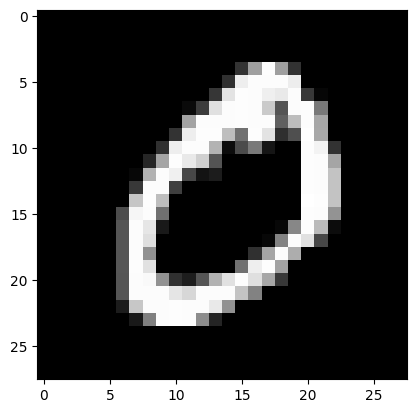

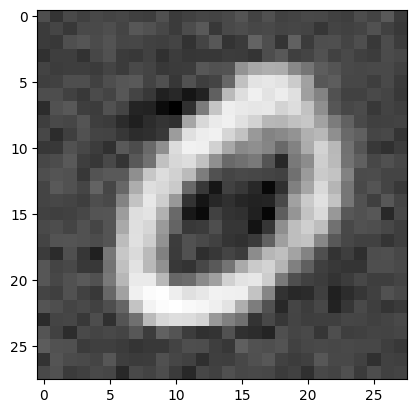

In [49]:
index = 1
plot_img(train.X[index]);plot_img(decoded[index])